Importing Libraries

In [10]:
#step 1:Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,confusion_matrix,classification_report,ConfusionMatrixDisplay,accuracy_score
!pip install openpyxl

Uploading and Loading Dataset-https://archive.ics.uci.edu/dataset/360/air+quality

In [11]:
#step 2:Upload Dataset
from google.colab import files
uploaded=files.upload()

Saving AirQualityUCI.xlsx to AirQualityUCI (1).xlsx


Cleaning the Dataset

In [12]:
df=pd.read_excel('AirQualityUCI.xlsx',engine='openpyxl')
#handling the missing values
df.replace(-200,np.nan,inplace=True)
#dropping empty columns
df.dropna(axis=1,how='all',inplace=True)
#checking for missing values
print(df.isnull().sum())
#replacing missing values by average
df.fillna(df.mean(numeric_only=True),inplace=True)
#combining date and time into datetime
df['Datetime']=pd.to_datetime(df['Date'].astype(str)+' '+df['Time'].astype(str),format= '%Y-%m-%d %H:%M:%S')
#dropping original date and time columns
df.drop(['Date','Time'],axis=1,inplace=True)
#extracting hours,weekdays and months
df['hour']=df['Datetime'].dt.hour
df['weekday']=df['Datetime'].dt.weekday
df['month']=df['Datetime'].dt.month
#saving the dataset
df.to_csv('cleaned_AirQualityUCI.csv',index=False,sep=';',decimal=',')
print('Dataset has been cleaned and saved successfully.')

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64
Dataset has been cleaned and saved successfully.


Loading the Dataset

In [13]:
#step 3:Load and Preview UCI Dataset
df = pd.read_csv('cleaned_AirQualityUCI.csv', sep=';', decimal=',', engine='python')
df.columns = df.columns.str.strip()
df = df.dropna()
# Create a simplified AQI column
df['AQI'] = df['CO(GT)'] * 0.6 + df['NO2(GT)'] * 0.4
df.head()
print(df.head())

   CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6      1360.00     150.0  11.881723        1045.50    166.0   
1     2.0      1292.25     112.0   9.397165         954.75    103.0   
2     2.2      1402.00      88.0   8.997817         939.25    131.0   
3     2.2      1375.50      80.0   9.228796         948.25    172.0   
4     1.6      1272.25      51.0   6.518224         835.50    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T         RH  \
0       1056.25    113.0       1692.00      1267.50  13.60  48.875001   
1       1173.75     92.0       1558.75       972.25  13.30  47.700000   
2       1140.00    114.0       1554.50      1074.00  11.90  53.975000   
3       1092.00    122.0       1583.75      1203.25  11.00  60.000000   
4       1205.00    116.0       1490.00      1110.00  11.15  59.575001   

         AH             Datetime  hour  weekday  month    AQI  
0  0.757754  2004-03-10 18:00:00    18        2      3  46.76  
1  0.7

Visualize AQI Distribution and Categories

In [14]:
import pandas as pd

# Load your dataset with the correct separator and decimal
df = pd.read_csv('cleaned_AirQualityUCI.csv', sep=';', decimal=',')

# --- Sub-index calculation function ---
def calculate_subindex(Cp, breakpoints):
    for bp_lo, bp_hi, I_lo, I_hi in breakpoints:
        if bp_lo <= Cp <= bp_hi:
            return ((I_hi - I_lo) / (bp_hi - bp_lo)) * (Cp - bp_lo) + I_lo
    return None  # If value out of range

# --- Define breakpoints ---

# CO (mg/m³) - CPCB India
co_breakpoints = [
    (0, 1, 0, 50), (1, 2, 51, 100), (2, 10, 101, 200),
    (10, 17, 201, 300), (17, 34, 301, 400), (34, 50, 401, 500)
]

# NO₂ (µg/m³) - CPCB India
no2_breakpoints = [
    (0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
    (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)
]

# C₆H₆ (µg/m³) - Approximate for research only
c6h6_breakpoints = [
    (0, 5, 0, 50), (5, 10, 51, 100), (10, 20, 101, 200),
    (20, 30, 201, 300), (30, 50, 301, 400), (50, 100, 401, 500)
]

# --- Apply subindex calculation ---
df['CO_SubIndex'] = df['CO(GT)'].apply(lambda x: calculate_subindex(x, co_breakpoints))
df['NO2_SubIndex'] = df['NO2(GT)'].apply(lambda x: calculate_subindex(x, no2_breakpoints))
df['C6H6_SubIndex'] = df['C6H6(GT)'].apply(lambda x: calculate_subindex(x, c6h6_breakpoints))

# --- Calculate final AQI ---
df['AQI'] = df[['CO_SubIndex', 'NO2_SubIndex', 'C6H6_SubIndex']].max(axis=1)

# --- Classify AQI Levels ---
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

df['AQI_Category'] = df['AQI'].apply(classify_aqi)

# --- Save updated dataset ---
df.to_csv('updated_aqi_dataset.csv', index=False)
print("AQI calculation complete. Sample data:")
print(df[['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'AQI', 'AQI_Category']])

AQI calculation complete. Sample data:
      CO(GT)  NO2(GT)   C6H6(GT)    AQI AQI_Category
0        2.6    113.0  11.881723  133.0     Moderate
1        2.0     92.0   9.397165  112.0     Moderate
2        2.2    114.0   8.997817  134.0     Moderate
3        2.2    122.0   9.228796  142.0     Moderate
4        1.6    116.0   6.518224  136.0     Moderate
...      ...      ...        ...    ...          ...
9352     3.1    189.8  13.529605  209.8         Poor
9353     2.4    179.2  11.355157  199.2     Moderate
9354     2.4    174.7  12.374538  194.7     Moderate
9355     2.1    155.7   9.547187  175.7     Moderate
9356     2.2    167.7  11.932060  187.7     Moderate

[9357 rows x 5 columns]


SMOTE techniques for tackling class imbalance

In [15]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.utils import to_categorical
import pandas as pd

# Step 1: Prepare your features (X) and labels (y)
x = df[['T', 'C6H6(GT)']]  # Features selected from dataset
y = df['AQI_Category']     # Categories: Good, Satisfactory, Moderate, etc.

# Step 2: Encode AQI categories into numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Transforms AQI categories into 0,1,...,5
print('Label mapping:')
for i, label in enumerate(le.classes_):
    print(f'{i}: {label}')
print("Class counts before SMOTE:", Counter(y_train))


# Step 3: Split data before applying SMOTE
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Step 4: Apply SMOTE to balance training data
smote = SMOTE(random_state=42, k_neighbors=3) # Set k_neighbors to 4
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Class distribution BEFORE SMOTE:", Counter(y_train))
print("Class distribution AFTER SMOTE:", Counter(y_train_resampled))

# Step 5: One-hot encode the resampled labels
y_train_ohe = to_categorical(y_train_resampled, num_classes=len(le.classes_))
y_test_ohe = to_categorical(y_test, num_classes=len(le.classes_))

# Check results
print("First 5 encoded labels before one-hot encoding:", y_train[:5])
print("First 5 after one-hot encoding:\n", y_train_ohe[:5])

Label mapping:
0: Good
1: Moderate
2: Poor
3: Satisfactory
4: Severe
5: Very Poor
Class counts before SMOTE: Counter({np.int64(1): 41, np.int64(0): 40, np.int64(2): 39})
Class distribution BEFORE SMOTE: Counter({np.int64(1): 5010, np.int64(3): 1165, np.int64(2): 953, np.int64(0): 192, np.int64(5): 161, np.int64(4): 4})
Class distribution AFTER SMOTE: Counter({np.int64(3): 5010, np.int64(2): 5010, np.int64(1): 5010, np.int64(5): 5010, np.int64(0): 5010, np.int64(4): 5010})
First 5 encoded labels before one-hot encoding: [3 2 1 1 3]
First 5 after one-hot encoding:
 [[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


Plotting resampled categories

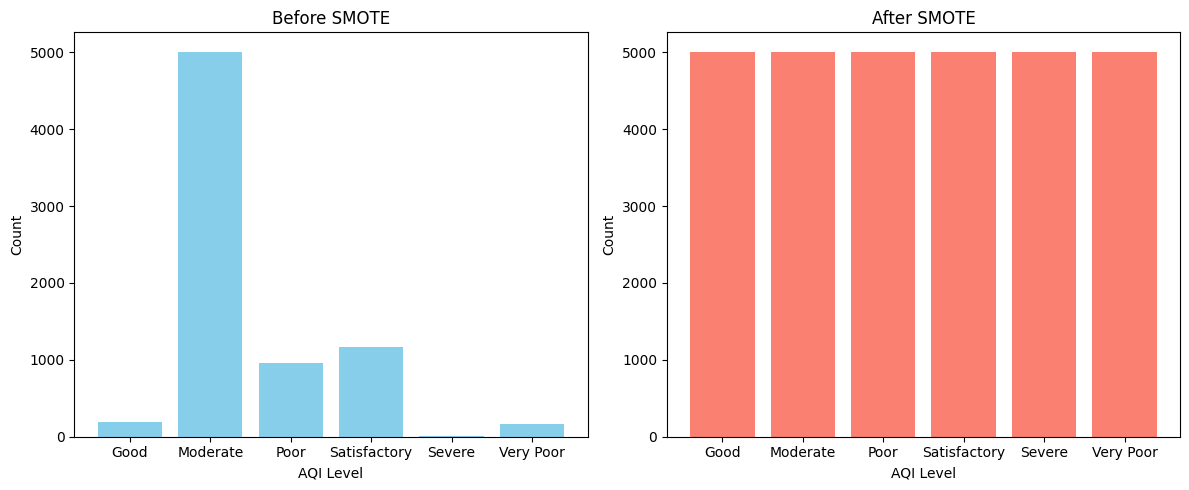

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Mapping back integer labels to original AQI_Level labels for visualization
label_names = le.classes_

# Count before and after resampling
before_counts = Counter(y_train)
after_counts = Counter(y_train_resampled)

# Create bar chart
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot before SMOTE
axs[0].bar(label_names, [before_counts[i] for i in range(len(label_names))], color='skyblue')
axs[0].set_title('Before SMOTE')
axs[0].set_xlabel('AQI Level')
axs[0].set_ylabel('Count')

# Plot after SMOTE
axs[1].bar(label_names, [after_counts[i] for i in range(len(label_names))], color='salmon')
axs[1].set_title('After SMOTE')
axs[1].set_xlabel('AQI Level')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Regression Model-Predict AQI

In [17]:
x=df[['T','C6H6(GT)']]
y=df['AQI']
x_train,x_test,y_train_resampled,y_test=train_test_split(x,y,test_size=0.2,random_state=20)
reg_model=RandomForestRegressor(n_estimators=100,random_state=42)
reg_model.fit(x_train,y_train_resampled)
y_pred=reg_model.predict(x_test)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
# R² Score
r2 = r2_score(y_test, y_pred)
# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 21.4715
Mean Squared Error (MSE): 899.5884
Root Mean Squared Error (RMSE): 29.9931
R² Score: 0.7295


Visualizing Predictions

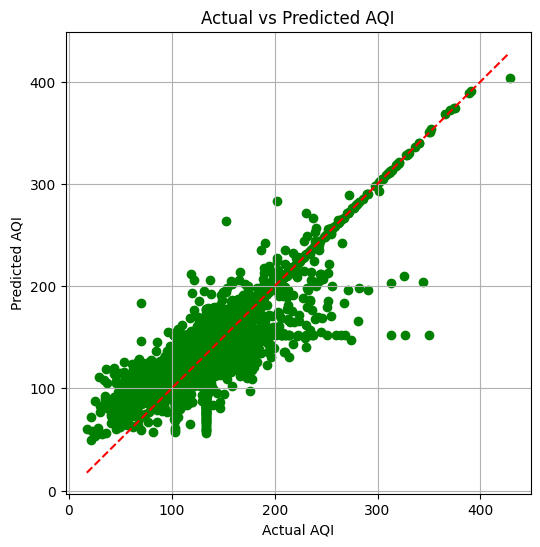

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='GREEN')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.grid(True)
plt.show()


Classification-Predict AQI Category

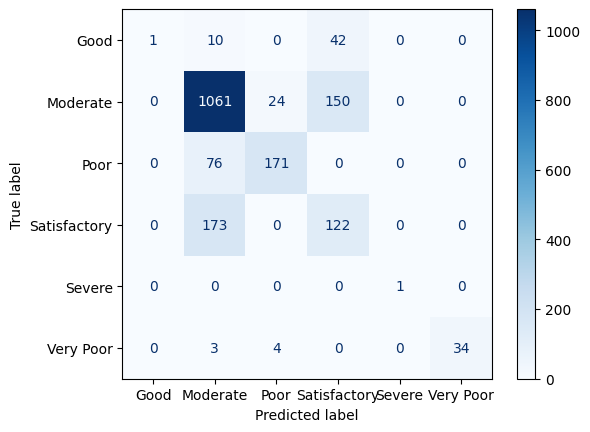

In [19]:
#--- Classify AQI Levels ---
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'


# Apply to both true and predicted values
y_test_class = pd.Series(y_test).apply(classify_aqi)
y_pred_class = pd.Series(y_pred).apply(classify_aqi)

cm = confusion_matrix(y_test_class, y_pred_class)

# Optional: set class names if you have them
class_names = sorted(list(set(y_test_class) | set(y_pred_class)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')

Testing the model with different values of input variables

In [22]:
def predict_aqi( temp,c6h6):
    input_data = pd.DataFrame([[ temp,c6h6]], columns=[ 'T','C6H6(GT)'])
    return reg_model.predict(input_data)[0]
#--- Classify AQI Levels ---
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'


#Giving the inputs to the model
temp_value = 15.0
c6h6_value = 9.2
# Predict AQI
predicted_aqi = predict_aqi(temp_value,c6h6_value)
# Classify AQI category
aqi_category = classify_aqi(predicted_aqi)
# Show result
print(f"🔹 Predicted AQI: {predicted_aqi:.2f}")
print(f"🔹 AQI Category: {aqi_category}")


🔹 Predicted AQI: 139.01
🔹 AQI Category: Moderate


Checking for Accuracy


 Accuracy: 0.7425213675213675

 Classification Report:
              precision    recall  f1-score   support

        Good       1.00      0.02      0.04        53
    Moderate       0.80      0.86      0.83      1235
        Poor       0.86      0.69      0.77       247
Satisfactory       0.39      0.41      0.40       295
      Severe       1.00      1.00      1.00         1
   Very Poor       1.00      0.83      0.91        41

    accuracy                           0.74      1872
   macro avg       0.84      0.64      0.66      1872
weighted avg       0.75      0.74      0.73      1872



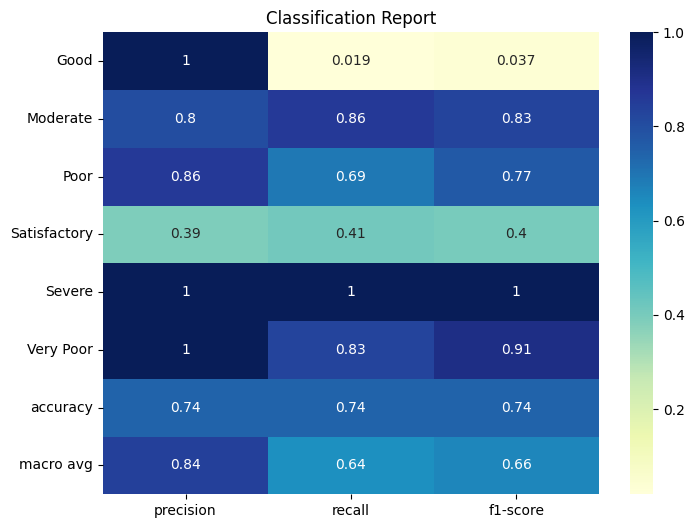

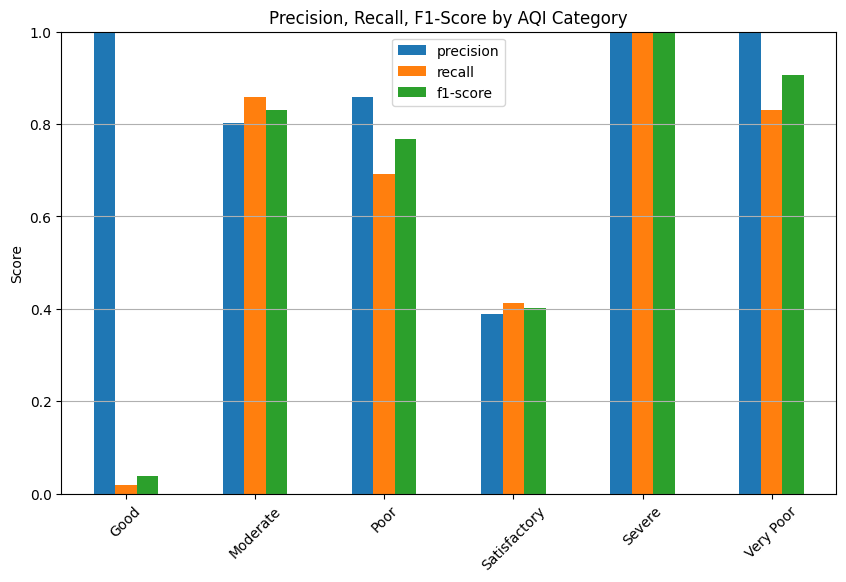

In [26]:
# Classification accuracy
print("\n Accuracy:", accuracy_score(y_test_class, y_pred_class))

# Classification report (precision, recall, f1-score)
print("\n Classification Report:")
print(classification_report(y_test_class, y_pred_class))
aqi_labels = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe', 'Very Poor']


# Get the classification report
report = classification_report(y_test_class, y_pred_class,target_names=aqi_labels, output_dict=True)

# Convert to DataFrame for plotting
df_report = pd.DataFrame(report).transpose()
#plotting the Classification heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.show()
#Extract precision, recall, f1-score for each class
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.iloc[:6]  # Only class rows

# Plot precision, recall, f1-score
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, F1-Score by AQI Category')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 1)
plt.show()

Plotting training v/s testing accuracies

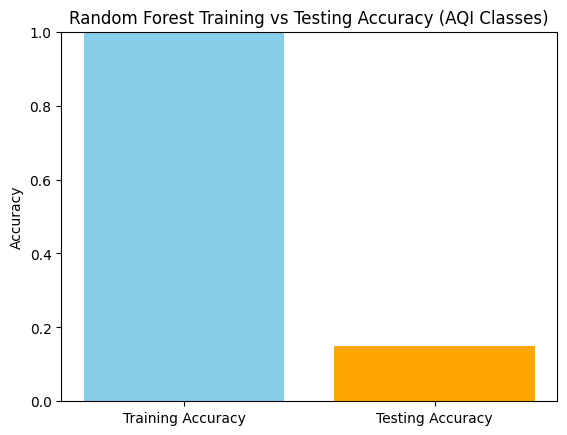

Training Accuracy: 1.0
Testing Accuracy: 0.15


In [29]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Example: Assume X contains features and y contains AQI values (continuous)
# Replace this with your actual AQI dataset
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 4) * 100  # Example features
y_aqi = np.random.randint(0, 500, 100)  # Example AQI values

# Function to map AQI values to classes
def aqi_to_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

# Convert AQI values to categorical labels
y_classes = np.array([aqi_to_category(val) for val in y_aqi])

# Train-test split
X_train, X_test, y_train_resampled, y_test = train_test_split(X, y_classes, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_resampled)

# Calculate accuracies
train_acc = accuracy_score(y_train_resampled, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

# Plot results
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_acc, test_acc], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Random Forest Training vs Testing Accuracy (AQI Classes)')
plt.show()

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)
